In [4]:
import json

import bz2
from tqdm import tqdm
from scipy import sparse

In [5]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:30, 2215.92it/s]


#  Домашнее задание по NLP # 2 [100 баллов] 
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [4]:
responses[99]

{'author': 'ronnichka',
 'bank_license': 'лицензия № 880',
 'bank_name': 'Югра',
 'city': 'г. Саратов',
 'datetime': '2015-06-03 20:56:57',
 'num_comments': 0,
 'rating_grade': 3,
 'rating_not_checked': False,
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'title': 'Карта ко вкладу'}

## Часть 1. Обучение модели word2vec [50 баллов]

### 1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. 

In [59]:
from nltk.tokenize import sent_tokenize

In [113]:
from pymystem3 import Mystem
import re


m = Mystem()


regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""



def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


In [114]:
#df = pd.DataFrame.from_dict(responses)

In [118]:
df = pd.read_csv("banki_responses.csv")

In [116]:
#df.to_csv("banki_responses.csv")

In [119]:
df = df.iloc[:10000]

разбиваем на предложения

In [120]:
sentences = []
for i in range(len(df)):
    sentences.extend(sent_tokenize(df.text.iloc[i]))

In [121]:
#sentences[:10]

лемматезируем

In [122]:
sentences = [words_only(sentence) for sentence in sentences]
sentences = [lemmatize(sentence) for sentence in sentences]

In [123]:
#sentences

готовим слова к Word2Vec

In [124]:
texts = [sentence.split() for sentence in sentences]

### 2. Обучите по коллекции предложений word2vec

In [125]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(texts, size=100, window=5, min_count=5, workers=4)

CPU times: user 16.2 s, sys: 89.7 ms, total: 16.3 s
Wall time: 5.19 s


### 3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:

###     * тест на определение ближайших слов

In [127]:
model.most_similar("вклад")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('депозит', 0.8753747940063477),
 ('картсчет', 0.5649868845939636),
 ('счет', 0.5369558930397034),
 ('капитализация', 0.43663525581359863),
 ('пролонгация', 0.4306020438671112),
 ('акция', 0.42829492688179016),
 ('доверенность', 0.4262858033180237),
 ('книжка', 0.4254279136657715),
 ('ставка', 0.42504727840423584),
 ('фк', 0.4205763339996338)]

###    * тест на аналогии (мужчина – король : женщина – королева)

In [133]:
model.most_similar(positive=["депозит","капитализация"], negative=["кредит"])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('новогодний', 0.6425111293792725),
 ('пополнение', 0.6249430775642395),
 ('доходность', 0.6176320314407349),
 ('рублевый', 0.5906823873519897),
 ('размещение', 0.5845530033111572),
 ('неснижать', 0.5837865471839905),
 ('валютный', 0.5837717056274414),
 ('максимальный', 0.5831655859947205),
 ('курсы', 0.5828506946563721),
 ('сейф', 0.5744236707687378)]

###    * тест на определение лишнего слова.

In [134]:
model.doesnt_match("карта счет банк быть".split())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'быть'

### 4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  

In [136]:
top_words = []
from nltk import FreqDist
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(100):
    top_words.append(i[0])
print(top_words)

['в', 'я', 'и', 'не', 'на', 'банк', 'что', 'с', 'быть', 'по', 'карта', 'мой', 'то', 'это', 'а', 'как', 'за', 'этот', 'но', 'к', 'день', 'о', 'у', 'кредит', 'деньги', 'сотрудник', 'который', 'так', 'клиент', 'вы', 'от', 'весь', 'они', 'свой', 'мочь', 'сумма', 'счет', 'отделение', 'для', 'она', 'год', 'же', 'из', 'заявление', 'сказать', 'такой', 'уже', 'получать', 'при', 'он', 'данный', 'вклад', 'до', 'договор', 'вопрос', 'все', 'т', 'номер', 'через', 'кредитный', 'ваш', 'мы', 'время', 'средство', 'нет', 'какой', 'раз', 'телефон', 'ответ', 'платеж', 'только', 'если', 'приходить', 'г', 'обращаться', 'звонок', 'тот', 'другой', 'после', 'один', 'сбербанк', 'еще', 'звонить', 'офис', 'месяц', 'рубль', 'проблема', 'или', 'бы', 'со', 'когда', 'ситуация', 'услуга', 'без', 'ни', 'написать', 'очень', 'информация', 'решать', 'позвонить']


In [137]:
top_words_vec = model[top_words]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [138]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [139]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

На построенных визуализациях мы можем наблюдать кластеры из слов общей тематики:
* день, месяц, год
* звонить, обращаться, приходить
* отделение, офис
* вклад, счет карта
и т. д.

In [140]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(top_words_vec)

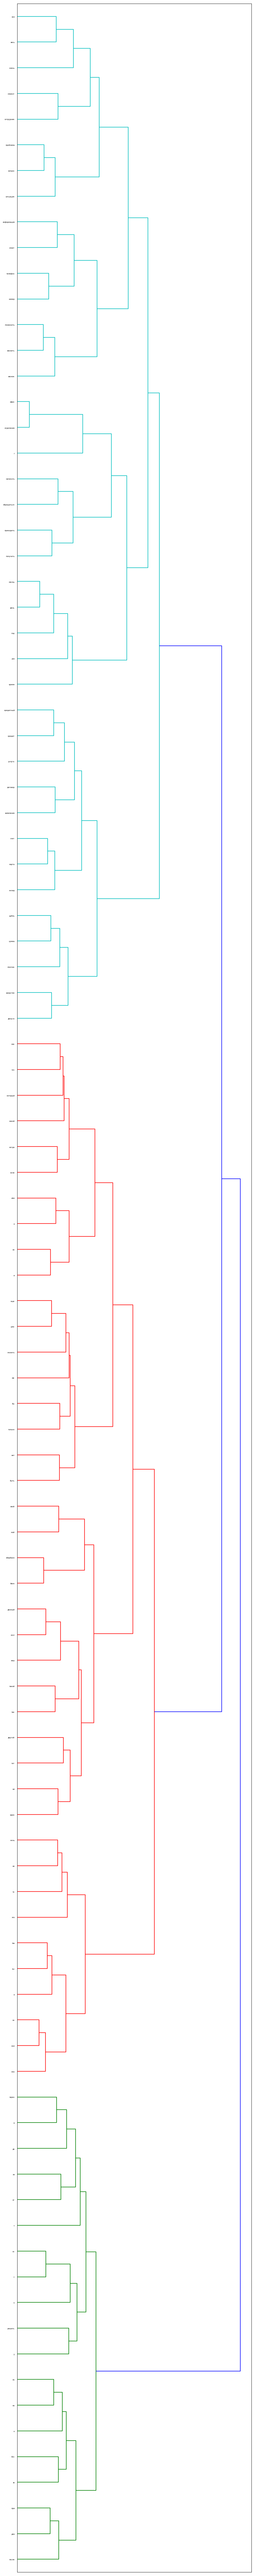

In [142]:
from scipy.cluster.hierarchy import  ward, dendrogram

linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 100)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=top_words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() 

## Часть 2. Распространение метки [50 баллов]

Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8  негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation``` 
3. ```sklearn.semi_supervised.LabelSpreading```

In [149]:
# пример построения графа 

import igraph as ig
g = ig.Graph(directed=True)
for word in model.wv.vocab.keys():
    g.add_vertex(word)
    
    
    
for word in model.wv.vocab.keys() :
    node = g.vs.select(name = word).indices[0]
    similar_words = model.most_similar(word, topn=5)
    for sim in similar_words:
        word1 = sim[0]
        val  = sim[1]
        new_node = g.vs.select(name = word1).indices[0]
        g.add_edge(node, new_node, weight = val)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if sys.path[0] == '':
